=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              69305 non-null  int64  
 1   name                            69305 non-null  object 
 2   host_id                         69305 non-null  int64  
 3   host_identity_verified          69305 non-null  object 
 4   host_name                       69305 non-null  object 
 5   neighbourhood_group             69305 non-null  object 
 6   neighbourhood                   69305 non-null  object 
 7   lat                             69305 non-null  float64
 8   long                            69305 non-null  float64
 9   instant_bookable                69305 non-null  bool   
 10  cancellation_policy             69305 non-null  object 
 11  room_type                       69305 non-null  object 
 12

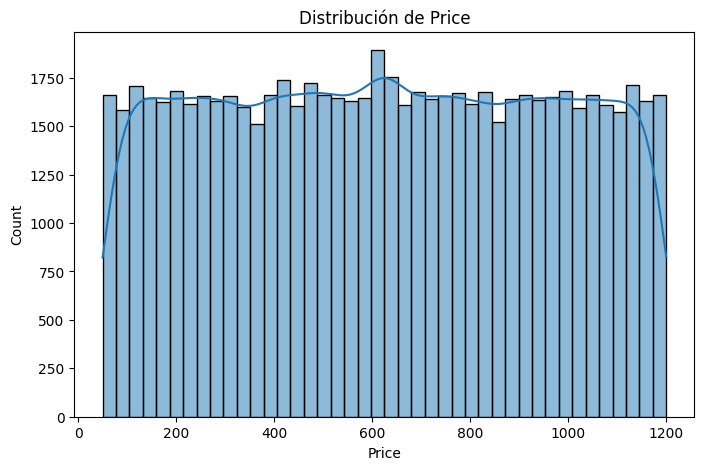

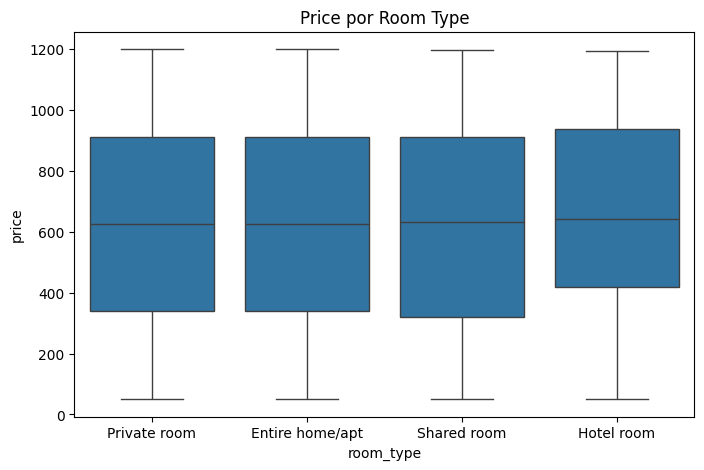

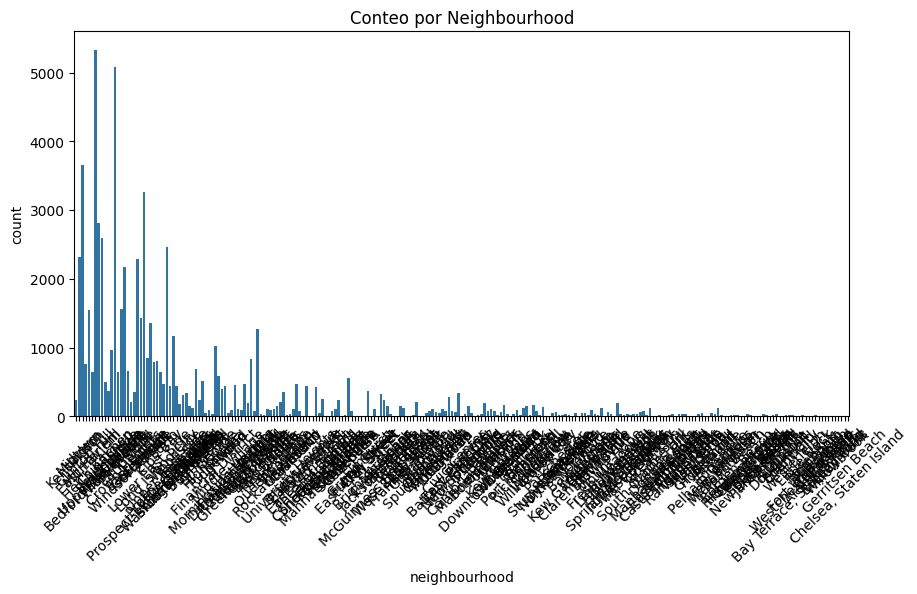

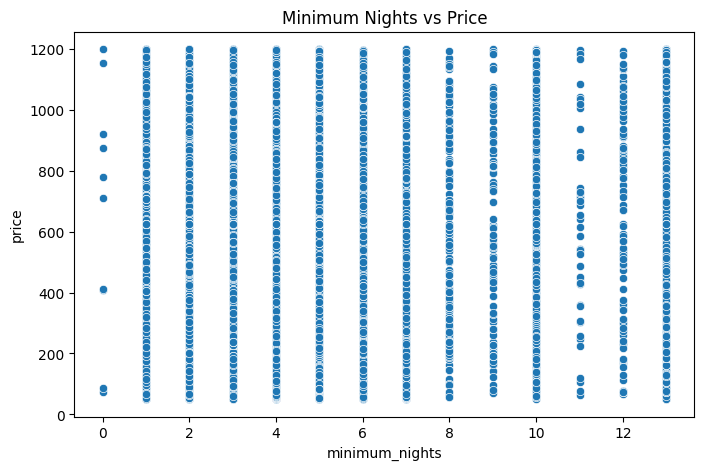

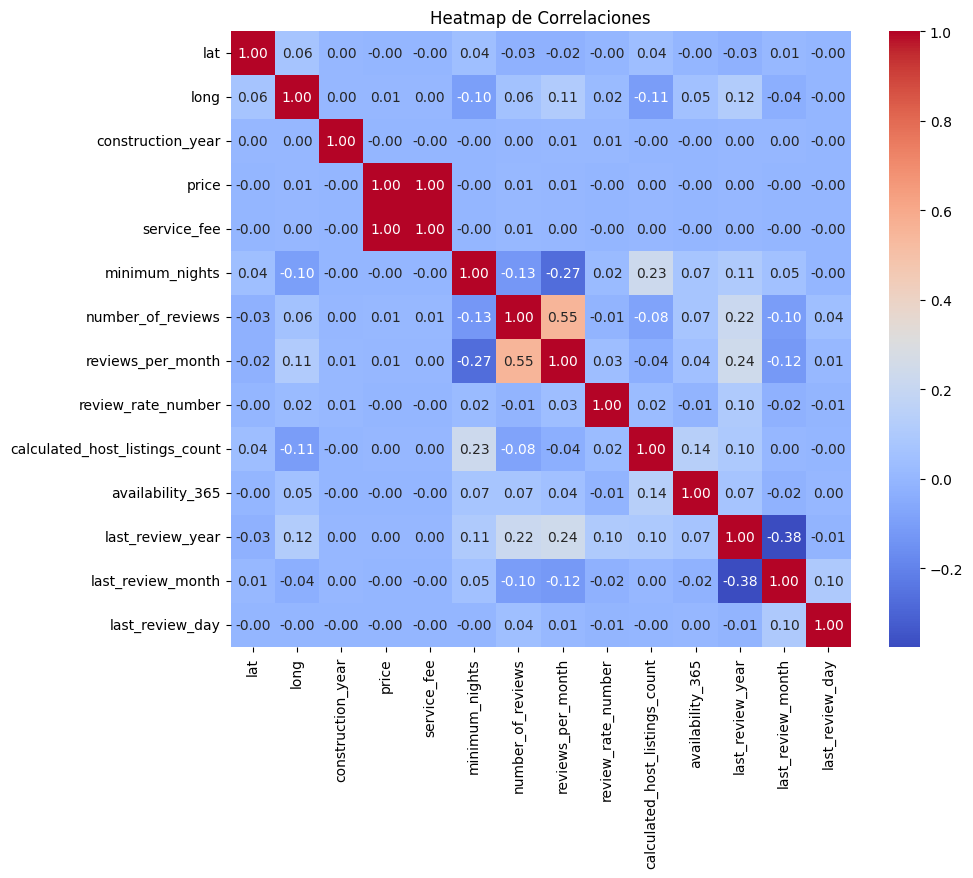

KeyError: "['latitude', 'longitude'] not in index"

In [ ]:
# =============================================================================
# 1. Carga de datos y exploración inicial
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesado con Scikit-Learn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, classification_report, confusion_matrix)

# Opcionales:
from sklearn.compose import TransformedTargetRegressor  # Para transformar target en regresión
from imblearn.over_sampling import SMOTE                 # Para balanceo de clases en clasificación
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import joblib

# Cargar el dataset (asegúrate de tener 'AirbnbNYCCleaned.csv' en la ruta)
df = pd.read_csv('airbnb_nyc_clean.csv')

# Exploración inicial
print("=== Información del DataFrame ===")
print(df.info())
print("\n=== Descripción Estadística ===")
print(df.describe())

# Corrección de errores o cambios de tipo (si es necesario)
# Por ejemplo: convertir columnas a tipo 'category' o 'datetime' según corresponda

# =============================================================================
# 1.a. Eliminación de columnas innecesarias
# =============================================================================
cols_eliminar = ['id', 'host_id', 'host_name']
df.drop(columns=cols_eliminar, inplace=True)
print("\nColumnas luego de eliminar id, host_id y host_name:")
print(df.columns)

# =============================================================================
# 1.b. Tratamiento de la fecha: descomponer en año, mes y día
# =============================================================================
# Se asume que la columna 'last_review' contiene fechas
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review_year']  = df['last_review'].dt.year
df['last_review_month'] = df['last_review'].dt.month
df['last_review_day']   = df['last_review'].dt.day

# (Opcional) Para un apartado independiente: eliminar filas donde 'last_review' es null
df_no_null = df.dropna(subset=['last_review'])
print("\nEjemplo de descomposición de 'last_review':")
print(df_no_null[['last_review_year','last_review_month','last_review_day']].head())

# =============================================================================
# 2. Análisis Exploratorio de Datos (EDA)
# =============================================================================

# 2.a. Univariante: Histograma de 'price'
plt.figure(figsize=(8,5))
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.show()

# 2.b. Univariante: Boxplot de 'price' según 'room_type'
plt.figure(figsize=(8,5))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Price por Room Type')
plt.show()

# 2.c. Univariante: Countplot para alguna variable categórica (ej. 'neighbourhood')
if 'neighbourhood' in df.columns:
plt.figure(figsize=(10,5))
sns.countplot(x='neighbourhood', data=df)
plt.title('Conteo por Neighbourhood')
plt.xticks(rotation=90)
plt.show()

# 2.d. Bivariante: Scatterplot entre 'minimum_nights' y 'price'
plt.figure(figsize=(8,5))
sns.scatterplot(x='minimum_nights', y='price', data=df)
plt.title('Minimum Nights vs Price')
plt.show()

# 2.e. Multivariante: Heatmap de correlaciones entre variables numéricas
plt.figure(figsize=(10,8))
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlaciones')
plt.show()

# 2.f. (Opcional) Pairplot para visualizar relaciones en variables numéricas
# sns.pairplot(df[num_cols])
# plt.show()

# =============================================================================
# 3. Definir el objetivo del modelado
# =============================================================================

# Se plantean dos problemas:
# - Regresión: predecir la columna 'price'
# - Clasificación: predecir la columna 'room_type'

# Para regresión:
X_reg = df.drop(columns=['price'])
y_reg = df['price']

# Para clasificación: se elimina 'price' para evitar fugas y se utiliza 'room_type' como target
X_clf = df.drop(columns=['price', 'room_type'])
y_clf = df['room_type']

# =============================================================================
# 4. Particionamiento/División de los datos para modelado
# =============================================================================

# División para regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# División para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# =============================================================================
# 5. Preprocesamiento con Scikit-Learn
# =============================================================================

# Identificar variables numéricas y categóricas en X_train_reg
numeric_features = X_train_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_reg.select_dtypes(include=['object']).columns.tolist()

# Si se desea vectorizar la columna de texto 'name' (opcional)
if 'name' in categorical_features:
    categorical_features.remove('name')
    text_feature = 'name'
else:
    text_feature = None

# Pipeline para variables numéricas: imputación y escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas: imputación y OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para columna de texto 'name' (opcional): vectorización y reducción de dimensionalidad
if text_feature:
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('svd', TruncatedSVD(n_components=50, random_state=42))
    ])

# ColumnTransformer que une los preprocesos
if text_feature:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('text', text_transformer, text_feature)
        ],
        remainder='drop'
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

# =============================================================================
# 6. Feature Engineering / Extraction / Selection
# =============================================================================

# 6.a. (Ya realizado) Ingeniería de fechas: se extrajeron año, mes y día de 'last_review'

# 6.b. Clustering: crear una columna 'cluster' usando KMeans con variables geográficas y 'price'
cluster_features = ['lat', 'longitude', 'price']
df_cluster = df[cluster_features].fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df_cluster)

# Visualizar clusters en un scatterplot (latitud vs longitud, coloreado por cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='Set1')
plt.title('Clusters (KMeans) según Latitud y Longitud')
plt.show()

# 6.c. Feature Selection para regresión: Seleccionar las 5 mejores variables numéricas usando SelectKBest
X_reg_numeric = X_train_reg[numeric_features].fillna(0)
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_reg_numeric, y_train_reg)
cols_selected = X_reg_numeric.columns[selector.get_support()]
print("\nVariables numéricas seleccionadas (SelectKBest para regresión):", list(cols_selected))

# 6.d. (Opcional) Feature Extraction para clasificación: Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=10, random_state=42)
# Se integrará dentro del pipeline de clasificación (ver sección 7.b)

# =============================================================================
# 7. Modelado
# =============================================================================

# 7.a. Regresión: Predecir 'price'
# Opción 1: Pipeline estándar sin transformación del target
model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', 
     # Por ejemplo, RandomForestRegressor
     # Se puede reemplazar por otros algoritmos como SVR, GradientBoostingRegressor, etc.
     __import__('sklearn.ensemble').ensemble.RandomForestRegressor(random_state=42)
    )
])

# Opción 2: Pipeline con transformación logarítmica del target usando TransformedTargetRegressor
model_reg_trans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=__import__('sklearn.ensemble').ensemble.RandomForestRegressor(random_state=42),
        func=np.log1p,           # Transformación: log(1 + x)
        inverse_func=np.expm1    # Inversa: exp(x) - 1
    ))
])

# Entrenamiento y evaluación de regresión
print("\n=== REGRESIÓN SIN TRANSFORMACIÓN DEL TARGET ===")
model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg.predict(X_test_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))

print("\n=== REGRESIÓN CON TRANSFORMACIÓN LOGARÍTMICA DEL TARGET ===")
model_reg_trans.fit(X_train_reg, y_train_reg)
y_pred_reg_trans = model_reg_trans.predict(X_test_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg_trans))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_trans))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg_trans))

# 7.b. Clasificación: Predecir 'room_type'
# Construimos tres pipelines:
#   - Sin SMOTE.
#   - Con SMOTE.
#   - Con PCA para reducción de dimensionalidad (opcional).

# Pipeline sin SMOTE
model_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', __import__('sklearn.ensemble').ensemble.RandomForestClassifier(random_state=42))
])

# Pipeline con SMOTE (usando imblearn)
model_clf_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', __import__('sklearn.ensemble').ensemble.RandomForestClassifier(random_state=42))
])

# Pipeline con PCA (opcional, para clasificación)
model_clf_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', __import__('sklearn.ensemble').ensemble.RandomForestClassifier(random_state=42))
])

# Entrenamiento y evaluación de clasificación
print("\n=== CLASIFICACIÓN SIN SMOTE ===")
model_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = model_clf.predict(X_test_clf)
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print("Reporte de Clasificación:\n", classification_report(y_test_clf, y_pred_clf))
print("Matriz de Confusión:\n", confusion_matrix(y_test_clf, y_pred_clf))

print("\n=== CLASIFICACIÓN CON SMOTE ===")
model_clf_smote.fit(X_train_clf, y_train_clf)
y_pred_clf_smote = model_clf_smote.predict(X_test_clf)
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf_smote))
print("Reporte de Clasificación:\n", classification_report(y_test_clf, y_pred_clf_smote))
print("Matriz de Confusión:\n", confusion_matrix(y_test_clf, y_pred_clf_smote))

print("\n=== CLASIFICACIÓN CON PCA ===")
model_clf_pca.fit(X_train_clf, y_train_clf)
y_pred_clf_pca = model_clf_pca.predict(X_test_clf)
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf_pca))
print("Reporte de Clasificación:\n", classification_report(y_test_clf, y_pred_clf_pca))
print("Matriz de Confusión:\n", confusion_matrix(y_test_clf, y_pred_clf_pca))

# =============================================================================
# 8. Comparar resultados de modelos con validación cruzada
# =============================================================================

# Validación cruzada para regresión (usando pipeline sin transformación)
cv_results_reg = cross_validate(model_reg, X_reg, y_reg, cv=5,
                                scoring=['r2', 'neg_mean_squared_error'],
                                return_train_score=True)
cv_reg_df = pd.DataFrame(cv_results_reg)
print("\n=== Resultados de Validación Cruzada para Regresión ===")
print(cv_reg_df)

plt.figure(figsize=(8,5))
sns.boxplot(data=cv_reg_df[['test_r2', 'test_neg_mean_squared_error']])
plt.title('Distribución de Métricas (Regresión)')
plt.show()

# Validación cruzada para clasificación (usando pipeline sin SMOTE)
cv_results_clf = cross_validate(model_clf, X_clf, y_clf, cv=5,
                                scoring=['accuracy'],
                                return_train_score=True)
cv_clf_df = pd.DataFrame(cv_results_clf)
print("\n=== Resultados de Validación Cruzada para Clasificación ===")
print(cv_clf_df)

plt.figure(figsize=(8,5))
sns.boxplot(data=cv_clf_df[['test_accuracy']])
plt.title('Distribución de Accuracy (Clasificación)')
plt.show()

# =============================================================================
# 9. Optimización del modelo: GridSearchCV (Opcional)
# =============================================================================

# Ejemplo: Ajuste de hiperparámetros para el pipeline de regresión (sin transformación)
param_grid_reg = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20]
}

grid_search_reg = GridSearchCV(model_reg, param_grid=param_grid_reg, cv=3,
                               scoring='r2', n_jobs=-1)
grid_search_reg.fit(X_train_reg, y_train_reg)
print("\nMejores hiperparámetros para Regresión:")
print(grid_search_reg.best_params_)
print("Mejor R2 en validación:", grid_search_reg.best_score_)

# =============================================================================
# 10. Exportación del modelo (Pipelines y producción)
# =============================================================================

# Una vez elegido el modelo final, se puede exportar usando joblib
joblib.dump(model_reg, 'modelo_regresion_airbnb.pkl')
joblib.dump(model_clf, 'modelo_clasificacion_airbnb.pkl')

print("\nModelos exportados exitosamente.")


In [ ]:
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Definimos el pipeline de preprocesamiento (ejemplo previo)
# Se asume que 'preprocessor' ya está definido (imputación, escalado, codificación, etc.)

# Pipeline de regresión con transformación del target
model_reg_trans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42),
        func=np.log1p,           # transformación logarítmica
        inverse_func=np.expm1    # reversión de la transformación
    ))
])

# División de datos para regresión (suponiendo que ya se tiene X_reg y y_reg)
from sklearn.model_selection import train_test_split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Entrenamiento y evaluación
model_reg_trans.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg_trans.predict(X_test_reg)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("Regresión con transformación del target:")
print("R2:", r2_score(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline de clasificación con SMOTE
model_clf_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# División de datos para clasificación (suponiendo que ya se tiene X_clf y y_clf)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# Entrenamiento y evaluación
model_clf_smote.fit(X_train_clf, y_train_clf)
y_pred_clf = model_clf_smote.predict(X_test_clf)

print("Clasificación con SMOTE:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print("Reporte de Clasificación:\n", classification_report(y_test_clf, y_pred_clf))
print("Matriz de Confusión:\n", confusion_matrix(y_test_clf, y_pred_clf))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Suponiendo que la columna 'name' existe en el DataFrame
# Separamos las columnas: numéricas, categóricas y la columna de texto 'name'
numeric_features = X_train_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_reg.select_dtypes(include=['object']).columns.tolist()

# Si 'name' está en las variables categóricas, la removemos para procesarla aparte
if 'name' in categorical_features:
    categorical_features.remove('name')

# Pipeline para procesar la columna de texto 'name'
text_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=50, random_state=42))
])

# Actualizamos el preprocessor para incluir la transformación de 'name'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_pipeline, 'name')
    ],
    remainder='drop'

In [ ]:
def build_regression_pipeline(preprocessor):
    """
    Crea y retorna un pipeline de regresión que incluye transformación logarítmica del target.
    """
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', TransformedTargetRegressor(
            regressor=RandomForestRegressor(random_state=42),
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])

def build_classification_pipeline(preprocessor, use_smote=False):
    """
    Crea y retorna un pipeline de clasificación.
    Si use_smote es True, incorpora SMOTE para balanceo de clases.
    """
    if use_smote:
        return ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
    else:
        return Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

# Ejemplo de uso:
reg_pipeline = build_regression_pipeline(preprocessor)
clf_pipeline = build_classification_pipeline(preprocessor, use_smote=True)

# Entrenamiento (usando datos ya particionados)
reg_pipeline.fit(X_train_reg, y_train_reg)
clf_pipeline.fit(X_train_clf, y_train_clf)

In [ ]:
#ALAN
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

X = df.drop('price', axis=1)
y = df['price']
# clasificación multiclase
# X = df.drop('room_type', axis=1)
# y = df['room_type']
model = DecisionTreeRegressor(random_state=42)
params = {
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(2,10),
    'criterion': ['squared_error', 'absolute_error']
}
grid = GridSearchCV(model, params, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'], refit='neg_mean_absolute_error', verbose=1) # cv=5 por defecto
grid.fit(X, y)